<a href="https://colab.research.google.com/github/AdiTiwa/AdiTiwa/blob/main/dag_stratification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    import cirq
    import networkx as nx
except:
    !pip install --quiet cirq networkx
    import cirq
    import networkx as nx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

using virtual topology $g: (g_v, g_e)$, circuit $c: (c_v, c_e)$, where $Q$ (physical qubits) $= V(c)$

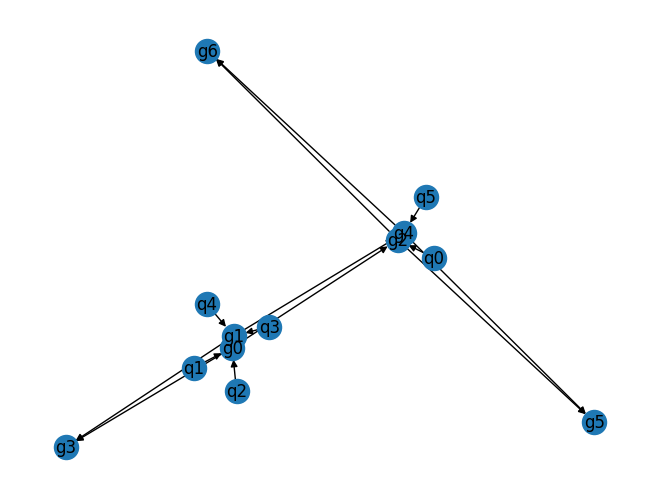

In [ ]:
g = nx.MultiGraph()
c = nx.DiGraph()

qubits = [f"q{i}" for i in range(0, 6)]
g.add_nodes_from((qubit, dict(virt=(i,))) for i, qubit in enumerate(qubits))
c.add_nodes_from((qubit, dict(qubits=(i,))) for i, qubit in enumerate(qubits))

g.add_edges_from([("q0", "q1"), ("q1", "q2"), ("q1", "q3"), ("q2", "q4"), ("q3", "q4"), ("q4", "q5")])

gates = [(1, 2), (3, 4), (0, 1), (2, 3), (4, 5), (0, 4), (1, 5)]

c.add_nodes_from((f"g{i}", dict(qubits=gates[i])) for i in range(len(gates)))

# tuple gate representation to circuit!
for idx, gate in enumerate(gates):
    for q in gate:
        current = f"q{q}"

        while True:
            out = c.out_edges(current)

            done = True
            for edge in out:
                if q == c.edges[edge]['qubit']:
                    current = edge[1]
                    done = False

            if done:
                break

        c.add_edge(current, f"g{idx}", qubit=q)

q = lambda x: f"q{x}"
gate = lambda x: f"g{x}"

nx.draw(c, with_labels=True)

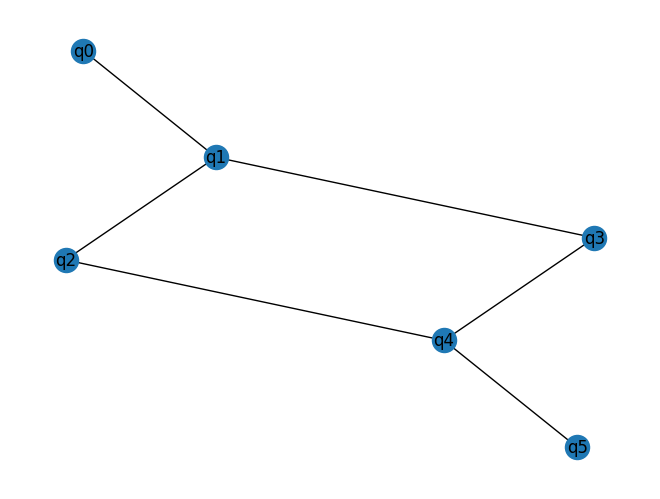

In [ ]:
nx.draw(g, with_labels=True)

In [ ]:
# initial virtual qubit lookup (structure that is mimiced for the tree)
vqs = dict(v0=0, v1=1, v2=2, v3=3, v4=4, v5=5) # (virtual = location \in Q) eg v1 \mapsto q0 \in V(g)

vq = lambda x, v: f"q{v[f'v{x}']}" # v \mapsto Q

In [ ]:
assert nx.is_directed_acyclic_graph(c)

stratas = list(nx.topological_generations(c))[1:]

In [ ]:
def find_all_paths(graph, start, end, path=[]):
    path = path + [start]
    if start == end:
        return [path]

    paths = []
    for node in graph.neighbors(start):
        if node not in path:
            newpaths = find_all_paths(graph, node, end, path)
            for newpath in newpaths:
                paths.append(newpath)

    return paths

In [ ]:
tree = nx.DiGraph() # decision tree for finding solution of circuit
tree.add_node("START", explored=False, ladder=[])

for strata in stratas:
    # find all vertexes in tree that haven't been explored based on their explored attribute
    unexplored = [node for node, data in tree.nodes(data=True) if not data['explored']]

    for child in unexplored:
        treevq = vqs.copy()

        for swap in tree.nodes[child]['ladder']:
            # swap locations of the values int(swap[-1]) in treevq
            treevq[swap[0]] = vq(swap[1], treevq)
            treevq[swap[1]] = vq(swap[0], treevq)

        for gate in strata:
            gate_index = int(gate[-1])

            qubit1 = vq(gates[gate_index][0], vqs)
            qubit2 = vq(gates[gate_index][1], vqs)

            if qubit1 in g.neighbors(qubit2):
                print(f"{gate} is just connected, continuing")
                continue
            else:
                print(f"{gate} is not connected")

                swaps = list( p[:-1] for p in find_all_paths(g, qubit1, qubit2) )
                ladders = [[(qubit1, step) for step in swap[1:]] for swap in swaps]

                for idx, swap in enumerate(swaps):
                    name = '->'.join(swap)
                    tree.add_node(name, ladder=ladders[idx])


g0 is just connected, continuing
g1 is just connected, continuing
g2 is just connected, continuing
g3 is not connected
[[('q2', 'q1')], [('q2', 'q4')]]
g4 is just connected, continuing
g5 is not connected
[[('q0', 'q1'), ('q0', 'q2')], [('q0', 'q1'), ('q0', 'q3')]]
g6 is not connected
[[('q1', 'q2'), ('q1', 'q4')], [('q1', 'q3'), ('q1', 'q4')]]
